# Wideband beam-steerable reflectarray with polarization-rotating unit cells

This example demonstrates how to design and optimize a wideband reflectarray based on polarization-rotating unit cells (PRUCs) using Tidy3D. The design is based on the work by [Luyen *et al*.](https://ieeexplore.ieee.org/document/8664570), where a reflectarray design is demonstrated with wide bandwidth and beam-steering capabilities using minimum-switch topology.

The design consists of:

* A polarization-rotating unit cell (PRUC) with two configurations (0° and 180° rotation)
* Arrow-shaped metallic patches on the top layer
* Ground plane with circular holes in the middle layer  
* Bottom layer with diagonal connecting strips, which enable the switching behavior
* Rogers RO4003C substrate layers bonded by Rogers RO4450B prepregs

<img src="img/reflectarray.png" width="400" alt="Rendering of a reflectarray constructed with the polarization-rotating unit cells">

Key features:

* Full-wave electromagnetic simulation of the unit cell using periodic boundary conditions
* Optimization of geometric parameters using Bayesian optimization
* Analysis of reflection coefficients and fractional bandwidth
* Cell designs achieving over 58% fractional bandwidth for cross-polarized reflection

This notebook shows how to:

1. Create parametric geometry for the PRUC design
2. Set up periodic boundary conditions and plane wave excitation
3. Configure optimization of key geometric parameters
4. Analyze reflection coefficients and bandwidth performance

Let's start by importing the required packages and defining some basic parameters.

In [1]:
# standard python imports
from copy import copy
from typing import Union

import matplotlib.pyplot as plt

# additional imports to aid in geometry processing and post-processing of results
import numpy as np
import pandas as pd
import shapely as shapely

# tidy3d imports
import tidy3d as td

# design plugin for performing the Bayesian optimization of the PRUC
import tidy3d.plugins.design as tdd
import xarray as xr

# dispersion plugin for fitting loss tangent to complex-conjugate pole-residue pair model
from tidy3d.plugins.dispersion import FastDispersionFitter

In [2]:
# Frequency range of interest is 8 to 12 GHz
freq_start = 4e9
freq_stop = 16e9
# Center frequency of 10 GHz
freq0 = (freq_start + freq_stop) / 2
fwidth = 9e9
# Center wavelength
wavelength0 = td.C_0 / freq0
# Longest wavelength
wavelength_start = td.C_0 / freq_start
freqs = np.linspace(freq_start, freq_stop, 101)
wvl_um = td.C_0 / freqs
run_time = 20e-9  # 20 ns run time

# Tidy3D uses microns by default
mm = 1e3
# Default unit cell parameters
S = 6 * mm  # size of the unit cell
s = 0.15 * mm  # spacing between arrow and unit cell boundary
l_stem = 2.7 * mm  # length of arrow from via center to tip
l_head = 2.75 * mm  # length of arrow head
w_stem = 0.25 * mm  # width of arrow stem
w_head = 0.7 * mm  # width of arrow head
d_via = 0.46 * mm  # Via diameter
w_cnx = 0.5 * mm  # Width of connector on bottom layer
# Custom parameters not given in [1]
w_via_pad = 0.5 * mm  # Width of via pad on the top layer
d_hole = 0.9 * mm  # Hole diameter in ground plane

# Substrate is three layers of Rogers RO4003C bonded by two layers of 0.1 mm
# thick Rogers RO4450B prepregs with total thickness 3.35 mm
prepreg_t = 0.102 * mm
l1_t = 0.813 * mm
l2_t = 1.524 * mm
l3_t = 0.813 * mm
structure_t = 2 * prepreg_t + l1_t + l2_t + l3_t
# Used to define grid discretization
dl_xy = 0.1 * mm  # resolution in the xy plane
dl_hole = 0.05 * mm  # grid resolution around ground plane holes
dl_z = 0.05 * mm  # resolution along the z axis
# Metals modeled as 35 microns thick
metal_t = 0.035 * mm

# Substrate material properties
RO4003C_er = 3.4
RO4003C_losstan = 0.0027
RO4450B_er = 3.54
RO4450B_losstan = 0.004

RO4003C = FastDispersionFitter.constant_loss_tangent_model(
    eps_real=RO4003C_er,
    loss_tangent=RO4003C_losstan,
    frequency_range=(freq_start, freq_stop),
    max_num_poles=3,
    tolerance_rms=1e-3,
)
RO4450B = FastDispersionFitter.constant_loss_tangent_model(
    eps_real=RO4450B_er,
    loss_tangent=RO4450B_losstan,
    frequency_range=(freq_start, freq_stop),
    max_num_poles=3,
    tolerance_rms=1e-3,
)

# All metals are modeled as perfect electric conductors
patch_metal = td.PEC

# Simulation domain definition with sufficient padding around the structure for PMLs
sim_size = (S, S, structure_t + wavelength_start / 2)
sim_center = [0, 0, 0]

Output()

Output()

## Helper Class Definitions
In this section, we define two helper classes which simplify the process of constructing the unit cell and reflectarray structure. Since the cells in this section are only needed for defining the Tidy3D structures, mesh overrides, and snapping points, feel free to skip to following section describing the [structure setup](#structure-setup).

### PRUC Geometry
We define a PRUC (Polarization-Rotating Unit Cell) helper class which creates the fundamental building block of the reflectarray.

The class is initialized by parameters describing the unit cell dimensions (cell size, arrow dimensions, via sizes, etc.)

- `calc_via_offset()` - Calculates where to place the vias in the unit cell
- `make_single_arrow()` - Creates coordinates for one arrow-shaped patch
- `make_all_arrows()` - Creates four rotated copies of the arrow for the unit cell
- `make_bottom_layer()` - Creates the bottom connecting strips
- `make_ground_layer()` - Creates the ground plane with holes
- `make_vias()` - Creates the connecting vias between layers
- `make_unit_cell_geometry()` - Assembles all components into complete unit cell

The class handles both 0° and 180° rotated versions of the unit cell through the `bit_version` parameter, which controls the orientation of the bottom layer connections.

In [3]:
class PRUC:
    """Class representing a Polarization-Rotating Unit Cell (PRUC) for reflectarray antennas.

    This class defines the geometry of a unit cell containing four arrow-shaped patches
    connected by vias through a ground plane. The cell can be rotated 0° or 180° to
    encode binary phase information.

    Attributes
    ----------
    S : float
        Size of the square unit cell aperture in microns.
    s : float
        Spacing between arrow patches and unit cell boundary in microns.
    l_head : float
        Length of the arrow head in microns.
    l_stem : float
        Length from via center to arrow tip in microns.
    w_stem : float
        Width of the arrow stem in microns.
    w_head : float
        Width of the arrow head in microns.
    w_via_pad : float
        Width of the square via pad on top layer in microns.
    w_cnx : float
        Width of the bottom layer connections between vias in microns.
    d_via : float
        Diameter of the metal vias in microns.
    d_hole : float
        Diameter of the holes in the ground plane in microns.
    metal_t : float
        Thickness of all metal layers in microns.
    z_top : float
        Z-coordinate of top substrate surface (excluding metal) in microns.
    z_ground : float
        Z-coordinate of ground plane substrate surface in microns.
    z_bottom : float
        Z-coordinate of bottom substrate surface (excluding metal) in microns.
    bit_version : bool
        If True, rotates bottom connections 180° to encode binary '1' state.
        If False, keeps 0° rotation for binary '0' state.
    """

    def __init__(
        self,
        S: float,
        s: float,
        l_head: float,
        l_stem: float,
        w_stem: float,
        w_head: float,
        w_via_pad: float,
        w_cnx: float,
        d_via: float,
        d_hole: float,
        metal_t: float,
        z_top: float,
        z_ground: float,
        z_bottom: float,
        bit_version: bool,
    ):
        self.S = S
        self.s = s
        self.l_head = l_head
        self.l_stem = l_stem
        self.w_stem = w_stem
        self.w_head = w_head
        self.w_via_pad = w_via_pad
        self.w_cnx = w_cnx
        self.d_via = d_via
        self.d_hole = d_hole
        self.metal_t = metal_t
        self.z_top = z_top
        self.z_ground = z_ground
        self.z_bottom = z_bottom
        self.bit_version = bit_version

    def calc_via_offset(self):
        """Calculates the offset of the via in the unit cell"""
        return self.S / 2 - self.s - self.l_stem / np.sqrt(2)

    def make_single_arrow(self) -> list[tuple[float, float]]:
        """Returns the 2D coordinates of a single arrow in the unit cell corresponding with the first quadrant."""

        def swap_xy(xy: tuple[float, float]):
            """Applies a reflection along the y = x line."""
            return (xy[1], xy[0])

        via_offset = self.l_stem / np.sqrt(2)

        # Create points along half of an arrow
        tr = (0, 0)
        br = (0, -self.l_head)
        br2 = (-self.w_head, -self.l_head)
        in_corner = (-self.w_head, -self.w_head - self.w_stem / np.sqrt(2))
        bl = (
            -via_offset + self.w_stem / np.sqrt(8),
            -via_offset - self.w_stem / np.sqrt(8),
        )
        # Complete arrow is created by reflecting points across y = x line
        arrow_points = [
            tr,
            br,
            br2,
            in_corner,
            bl,
            swap_xy(bl),
            swap_xy(in_corner),
            swap_xy(br2),
            swap_xy(br),
            swap_xy(tr),
        ]
        # Use shapely polygon operations to create the union of the arrow and via pad.
        arrow = shapely.Polygon(arrow_points)
        via_pad = shapely.box(
            -via_offset - 0.5 * self.w_via_pad,
            -via_offset - 0.5 * self.w_via_pad,
            -via_offset + 0.5 * self.w_via_pad,
            -via_offset + 0.5 * self.w_via_pad,
        )
        arrow_shapely = shapely.union(arrow, via_pad)
        return arrow_shapely.exterior.coords

    def make_all_arrows(self) -> list[td.PolySlab]:
        """Returns a list of all arrows in the unit cell by using rotations and translations."""
        slab_bounds = (self.z_top, self.z_top + self.metal_t)
        arrow_tr_verts = np.array(self.make_single_arrow())
        arrow_tl_verts = np.copy(arrow_tr_verts)
        arrow_tl_verts[:, 0] *= -1
        arrow_bl_verts = np.copy(arrow_tl_verts)
        arrow_bl_verts[:, 1] *= -1
        arrow_br_verts = np.copy(arrow_tr_verts)
        arrow_br_verts[:, 1] *= -1

        corner_offset = self.S / 2 - self.s

        arrow_tr_verts += np.array([corner_offset, corner_offset])
        arrow_tr = td.PolySlab(vertices=arrow_tr_verts, axis=2, slab_bounds=slab_bounds)
        arrow_tl_verts += np.array([-corner_offset, corner_offset])
        arrow_tl = td.PolySlab(vertices=arrow_tl_verts, axis=2, slab_bounds=slab_bounds)
        arrow_bl_verts += np.array([-corner_offset, -corner_offset])
        arrow_bl = td.PolySlab(vertices=arrow_bl_verts, axis=2, slab_bounds=slab_bounds)
        arrow_br_verts += np.array([corner_offset, -corner_offset])
        arrow_br = td.PolySlab(vertices=arrow_br_verts, axis=2, slab_bounds=slab_bounds)
        return [arrow_tr, arrow_tl, arrow_bl, arrow_br]

    def make_bottom_layer(self) -> td.Geometry:
        """Returns the bottom layer of the unit cell"""
        via_center = self.calc_via_offset()

        # Horizontal connections
        zcenter = self.z_bottom - self.metal_t / 2
        thickness = self.metal_t
        strip = td.Box(
            center=(0, 0, zcenter),
            size=(
                2 * np.sqrt(2) * (via_center) + self.d_via + (self.w_cnx - self.d_via),
                self.w_cnx,
                thickness,
            ),
        )
        angle = -np.pi / 4
        if self.bit_version:
            angle = np.pi / 4

        rotate_45 = td.Transformed.rotation(axis=2, angle=angle)
        strip = td.Transformed(geometry=strip, transform=rotate_45)

        geo_tuple = (strip,)

        metal_regions = td.GeometryGroup(geometries=geo_tuple)
        return metal_regions

    def make_ground_layer(self, ground_width: float = None) -> td.Geometry:
        """Returns the ground layer of the unit cell"""
        zcenter = self.z_ground + self.metal_t / 2
        thickness = self.metal_t
        via_center = self.calc_via_offset()

        ground_size = (self.S, self.S, thickness)
        if ground_width is not None:
            ground_size = (ground_width, ground_width, thickness)

        ground = td.Box(center=(0, 0, zcenter), size=ground_size)
        hole_size = (self.d_hole, self.d_hole, thickness)
        hole_tr = td.Box(center=(via_center, via_center, zcenter), size=hole_size)
        hole_tl = td.Box(center=(-via_center, via_center, zcenter), size=hole_size)
        hole_bl = td.Box(center=(-via_center, -via_center, zcenter), size=hole_size)
        hole_br = td.Box(center=(via_center, -via_center, zcenter), size=hole_size)
        holes = td.GeometryGroup(geometries=(hole_tr, hole_tl, hole_bl, hole_br))
        ground_with_holes = td.ClipOperation(
            operation="difference", geometry_a=ground, geometry_b=holes
        )
        return ground_with_holes

    def make_vias(self) -> tuple[td.Cylinder, td.Cylinder, td.Cylinder, td.Cylinder]:
        """Returns the vias in the unit cell"""
        via_center = self.calc_via_offset()
        center_z = (self.z_top + self.z_bottom) / 2
        length = self.z_top - self.z_bottom
        radius = self.d_via / 2
        tr = td.Cylinder(
            center=(via_center, via_center, center_z),
            length=length,
            radius=radius,
            axis=2,
        )
        tl = td.Cylinder(
            center=(-via_center, via_center, center_z),
            length=length,
            radius=radius,
            axis=2,
        )
        bl = td.Cylinder(
            center=(-via_center, -via_center, center_z),
            length=length,
            radius=radius,
            axis=2,
        )
        br = td.Cylinder(
            center=(via_center, -via_center, center_z),
            length=length,
            radius=radius,
            axis=2,
        )
        return tr, tl, bl, br

    def make_unit_cell_geometry(
        self, dl_hole: float, ground_width: float = None
    ) -> tuple[
        td.GeometryGroup,
        list[td.MeshOverrideStructure],
        list[tuple[float, float, float]],
    ]:
        """Returns the geometry of the metallic portion of the unit cell,
        mesh overrides around the holes, and the vertices of the arrows."""
        arrows = self.make_all_arrows()
        bottom_geometry = self.make_bottom_layer()
        ground_with_holes = self.make_ground_layer(ground_width)
        via_geometry = self.make_vias()
        all_geometries = tuple(
            arrows + [bottom_geometry] + [ground_with_holes] + list(via_geometry)
        )
        geometry_group = td.GeometryGroup(geometries=all_geometries)

        # Make regions of mesh refinement
        mesh_overrides = [
            td.MeshOverrideStructure(geometry=hole, dl=[dl_hole, dl_hole, self.metal_t])
            for hole in ground_with_holes.geometry_b.geometries
        ]

        # Get arrow vertices for snapping points
        arrow_verts = [
            (vert[0], vert[1], self.z_top) for arrow in arrows for vert in arrow.vertices
        ]
        return geometry_group, mesh_overrides, arrow_verts

### PRUC Array Structure Construction

The `PRUCArray` class handles the construction of a complete reflectarray antenna by arranging multiple Polarization-Rotating Unit Cells (PRUCs) in a regular grid. It manages:

- Assembly of unit cells in an Nx × Ny array configuration
- Creation of substrate and prepreg layers
- Specification of material properties
- Definition of mesh refinement regions

Key methods:

- `make_substrates()`: Creates the layered dielectric structure
- `make_array()`: Constructs the full reflectarray using a binary mask to determine cell rotations

The array construction supports:

- Arbitrary array dimensions through `Nx` and `Ny` parameters
- Extended substrate areas beyond the unit cell boundaries
- Custom mesh refinement around critical features
- Material specifications for substrates, prepregs, and metals

In [4]:
class PRUCArray:
    """Class representing an array of Polarization-Rotating Unit Cells (PRUCs).

    This class handles the construction of a reflectarray consisting of multiple PRUCs,
    including substrate layers and mesh refinement specifications.

    Attributes
    ----------
    unit_cell_0 : PRUC
        Unit cell representing binary '0' state with 0° rotation.
    unit_cell_1 : PRUC
        Unit cell representing binary '1' state with 180° rotation.
    Nx : int
        Number of unit cells along x-axis.
    Ny : int
        Number of unit cells along y-axis.
    array_sx : float
        Size of array in x-direction in microns. Allows for substrates that extend farther than the unit cells.
    array_sy : float
        Size of array in y-direction in microns. Allows for substrates that extend farther than the unit cells.
    prepreg_t : float
        Thickness of prepreg layers in microns.
    l1_t : float
        Thickness of top substrate layer in microns.
    l2_t : float
        Thickness of middle substrate layer in microns.
    l3_t : float
        Thickness of bottom substrate layer in microns.
    substrate_medium : Medium
        Material properties of the substrate layers.
    prepreg_medium : Medium
        Material properties of the prepreg layers.
    metal_medium : Medium
        Material properties of the metal layers.
    dl_hole : float
        Mesh cell size for refinement around holes in microns.
    dl_xy : float
        Mesh cell size in xy-plane in microns.
    dl_z : float
        Mesh cell size in z-direction in microns.
    """

    def __init__(
        self,
        unit_cell_0: PRUC,
        unit_cell_1: PRUC,
        Nx,
        Ny,
        array_sx,
        array_sy,
        prepreg_t,
        l1_t,
        l2_t,
        l3_t,
        substrate_medium,
        prepreg_medium,
        metal_medium,
        dl_hole: float,
        dl_xy: float,
        dl_z: float,
    ):
        self.unit_cell_0 = unit_cell_0
        self.unit_cell_1 = unit_cell_1
        self.Nx = Nx
        self.Ny = Ny
        self.array_sx = array_sx
        self.array_sy = array_sy
        self.prepreg_t = prepreg_t
        self.l1_t = l1_t
        self.l2_t = l2_t
        self.l3_t = l3_t
        self.substrate_medium = substrate_medium
        self.prepreg_medium = prepreg_medium
        self.metal_medium = metal_medium
        self.dl_hole = dl_hole
        self.dl_xy = dl_xy
        self.dl_z = dl_z

    def make_substrates(
        self,
    ) -> tuple[list[td.Structure], list[td.MeshOverrideStructure]]:
        """Create the layered substrate structure for the reflectarray along
        with mesh overrides that refine the mesh along the normal axis of the layers."""
        top_l1 = 0
        top_l2 = top_l1 - self.l1_t - self.prepreg_t
        top_l3 = top_l2 - self.l2_t - self.prepreg_t
        bottom = top_l3 - self.l3_t

        metal_t = self.unit_cell_0.metal_t

        array_sx = self.array_sx
        array_sy = self.array_sy

        sub1 = td.Structure(
            geometry=td.Box(
                center=(0, 0, top_l1 - self.l1_t / 2),
                size=(array_sx, array_sy, self.l1_t),
            ),
            medium=self.substrate_medium,
        )
        prepreg1 = td.Structure(
            geometry=td.Box(
                center=(0, 0, top_l1 - self.l1_t - self.prepreg_t / 2),
                size=(array_sx, array_sy, self.prepreg_t),
            ),
            medium=self.prepreg_medium,
        )
        sub2 = td.Structure(
            geometry=td.Box(
                center=(0, 0, top_l2 - self.l2_t / 2),
                size=(array_sx, array_sy, self.l2_t),
            ),
            medium=self.substrate_medium,
        )
        prepreg2 = td.Structure(
            geometry=td.Box(
                center=(0, 0, top_l2 - self.l2_t - self.prepreg_t / 2),
                size=(array_sx, array_sy, self.prepreg_t),
            ),
            medium=self.prepreg_medium,
        )
        sub3 = td.Structure(
            geometry=td.Box(
                center=(0, 0, top_l3 - self.l3_t / 2),
                size=(array_sx, array_sy, self.l3_t),
            ),
            medium=self.substrate_medium,
        )

        substrates = [sub1, prepreg1, sub2, prepreg2, sub3]

        patch_box = td.Box(center=(0, 0, top_l1 + metal_t / 2), size=(array_sx, array_sy, metal_t))
        ground_box = td.Box(
            center=(0, 0, top_l3 + metal_t / 2),
            size=(array_sx, array_sy, metal_t),
        )
        bottom_box = td.Box(
            center=(0, 0, bottom - metal_t / 2),
            size=(array_sx, array_sy, metal_t),
        )

        dl_metals = (self.dl_xy, self.dl_xy, metal_t)
        dl_subs = (self.dl_xy, self.dl_xy, self.dl_z)

        substrate_overrides = [
            td.MeshOverrideStructure(geometry=patch_box, dl=dl_metals),
            td.MeshOverrideStructure(geometry=ground_box, dl=dl_metals),
            td.MeshOverrideStructure(geometry=bottom_box, dl=dl_metals),
            td.MeshOverrideStructure(geometry=prepreg1.geometry, dl=dl_subs),
            td.MeshOverrideStructure(geometry=prepreg2.geometry, dl=dl_subs),
            td.MeshOverrideStructure(geometry=sub1.geometry, dl=dl_subs),
            td.MeshOverrideStructure(geometry=sub2.geometry, dl=dl_subs),
            td.MeshOverrideStructure(geometry=sub3.geometry, dl=dl_subs),
        ]
        return substrates, substrate_overrides

    def make_array(
        self, bit_mask: Union[xr.DataArray, bool], ground_width: float = None
    ) -> tuple[
        td.GeometryGroup,
        list[td.MeshOverrideStructure],
        list[tuple[float, float, float]],
    ]:
        """Returns all Tidy3D structures, mesh overrides and snapping points for the array."""
        S = self.unit_cell_0.S
        xstart = -self.Nx / 2.0 * S + 0.5 * S
        ystart = -self.Ny / 2.0 * S + 0.5 * S

        substrate_structures, substrate_overrides = self.make_substrates()

        geo_unit_cell_0, cell_overrides, cell_snapping_points = (
            self.unit_cell_0.make_unit_cell_geometry(
                dl_hole=self.dl_hole, ground_width=ground_width
            )
        )
        geo_unit_cell_1, _, _ = self.unit_cell_1.make_unit_cell_geometry(
            dl_hole=self.dl_hole, ground_width=ground_width
        )

        def get_cell_variant(i, j):
            if type(bit_mask) is bool:
                return bit_mask
            return bit_mask[i, j].item()

        unit_cell_geos = []
        mesh_overrides = []
        arrow_snapping_points = []
        for i in range(0, self.Nx):
            dx = xstart + i * S
            for j in range(0, self.Ny):
                dy = ystart + j * S
                # Add translated geometries
                translate = td.Transformed.translation(dx, dy, 0)
                if get_cell_variant(i, j):
                    transformed_cell = td.Transformed(geometry=geo_unit_cell_1, transform=translate)
                else:
                    transformed_cell = td.Transformed(geometry=geo_unit_cell_0, transform=translate)
                unit_cell_geos.append(transformed_cell)

                # Add mesh overrides
                mesh_overrides += [
                    override_hole.updated_copy(
                        path="geometry",
                        center=(
                            dx + override_hole.geometry.center[0],
                            dy + override_hole.geometry.center[1],
                            override_hole.geometry.center[2],
                        ),
                    )
                    for override_hole in cell_overrides
                ]

                # Add snapping points
                arrow_snapping_points += [
                    (v[0] + dx, v[1] + dy, v[2]) for v in cell_snapping_points
                ]

        all_cells = td.GeometryGroup(geometries=unit_cell_geos)
        all_cells_structure = td.Structure(geometry=all_cells, medium=self.metal_medium)

        all_structures = substrate_structures + [all_cells_structure]
        all_mesh_overrides = substrate_overrides + mesh_overrides

        return all_structures, all_mesh_overrides, arrow_snapping_points

## Setup
### Structure Setup

Using the helper classes defined earlier, we create an array consisting of a single unit cell, since in this notebook we are interested in optimizing the unit cell design [1].

We plot a candidate unit cell in the figures below.

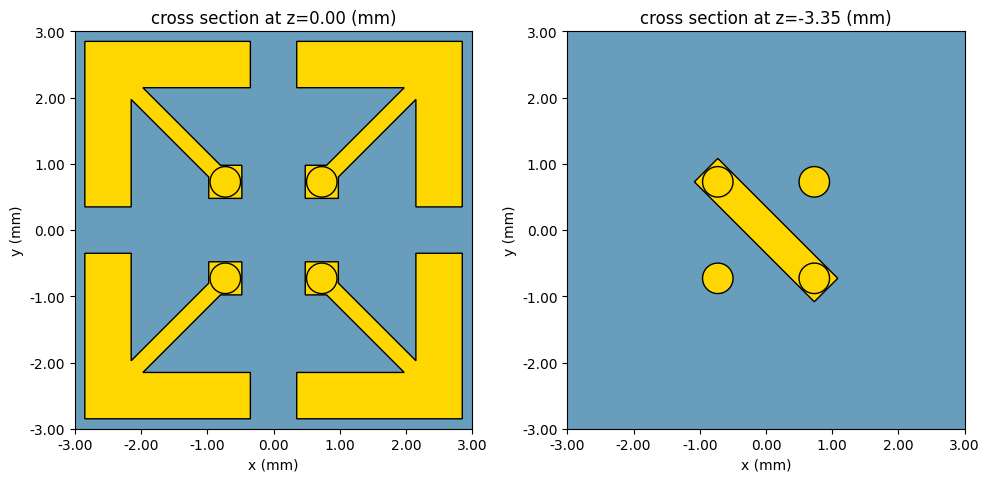

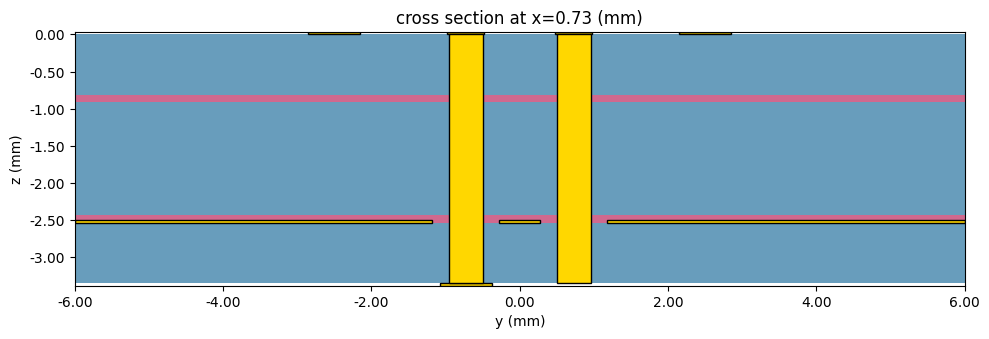

In [5]:
# Positions of the substrate interfaces
top_l1 = 0
top_l2 = top_l1 - l1_t - prepreg_t
top_l3 = top_l2 - l2_t - prepreg_t
bottom = top_l3 - l3_t
substrate_width = 2 * S

unit_cell_1 = PRUC(
    S=S,
    s=s,
    l_head=2.5 * mm,  # l1,
    l_stem=3 * mm,  # l2,
    w_stem=w_stem,
    w_head=w_head,
    w_via_pad=w_via_pad,
    w_cnx=w_cnx,
    d_via=d_via,
    d_hole=d_hole,
    metal_t=metal_t,
    z_top=0.0,
    z_ground=top_l3,
    z_bottom=bottom,
    bit_version=True,
)

unit_cell_0 = copy(unit_cell_1)
unit_cell_0.bit_version = False

array = PRUCArray(
    unit_cell_0=unit_cell_0,
    unit_cell_1=unit_cell_1,
    Nx=1,
    Ny=1,
    array_sx=substrate_width,  # Make array large enough that the substrates extend passed the simulation boundaries
    array_sy=substrate_width,
    prepreg_t=prepreg_t,
    l1_t=l1_t,
    l2_t=l2_t,
    l3_t=l3_t,
    substrate_medium=RO4003C,
    prepreg_medium=RO4450B,
    metal_medium=patch_metal,
    dl_hole=dl_hole,
    dl_xy=dl_xy,
    dl_z=dl_z,
)

mask = np.ones((array.Nx, array.Ny), dtype=bool)
mask[0, 0] = False
bool_array = xr.DataArray(
    mask,  # The value (can be False too)
    dims=["x", "y"],  # Names of the dimensions
)

all_structures, all_mesh_overrides, arrow_snapping_points = array.make_array(
    bit_mask=bool_array, ground_width=substrate_width
)

via_center = unit_cell_1.calc_via_offset()
scene = td.Scene(structures=all_structures, plot_length_units="mm")
fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
scene.plot(ax=axs[0], z=top_l1, hlim=[-3 * mm, 3 * mm], vlim=[-3 * mm, 3 * mm])
scene.plot(ax=axs[1], z=bottom, hlim=[-3 * mm, 3 * mm], vlim=[-3 * mm, 3 * mm])
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
scene.plot(ax=axs, x=via_center)
plt.show()

### Simulation Setup

Now we set up the electromagnetic simulation to characterize the PRUC. We use periodic boundary conditions in x and y to model an infinite array. A ``FieldMonitor`` is added just above the source to capture the reflected waves.

10:15:24 CEST WARNING:  ℹ️ ⚠️ RF simulations are subject to new license           
              requirements in the future. You are using RF-specific components  
              in this simulation.                                               
               - Contains monitors defined for RF wavelengths.                  

Number of cells: [88, 88, 137]
Smallest cell size (μm): (35.66, 35.66, 33.50)


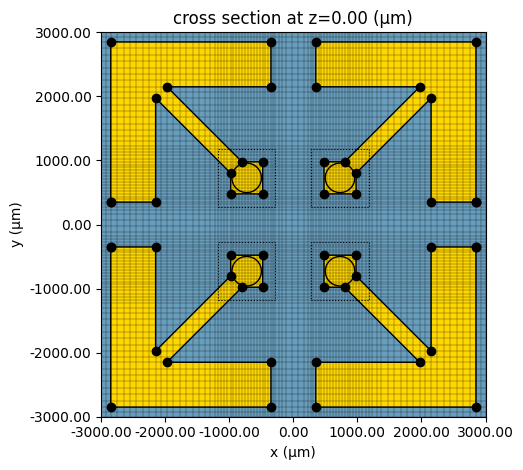

In [6]:
boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(),
    y=td.Boundary.periodic(),
    z=td.Boundary.pml(),
)

time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
planewave = td.PlaneWave(
    size=(td.inf, td.inf, 0),
    center=(0, 0, 5 * mm),
    source_time=time,
    direction="-",
    pol_angle=np.pi / 2,
    num_freqs=1,
)

R_mon = td.FieldMonitor(
    size=(td.inf, td.inf, 0), center=(0, 0, 15 * mm), name="reflection", freqs=freqs
)

sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=10,
        wavelength=td.C_0 / freq_stop,
        override_structures=all_mesh_overrides,
        snapping_points=arrow_snapping_points,
        dl_min=0.018 * mm,
    ),
    structures=all_structures,
    sources=[planewave],
    monitors=[R_mon],
    run_time=run_time,
    boundary_spec=boundary_spec,
)

print(f"Number of cells: {sim.grid.num_cells}")
print(
    f"Smallest cell size (μm): ({np.min(sim.grid.sizes.x):.2f}, {np.min(sim.grid.sizes.y):.2f}, {np.min(sim.grid.sizes.z):.2f})"
)

ax = sim.plot(z=top_l1)
ax = sim.plot_grid(ax=ax, z=top_l1)
plt.show()

### Bayesian Optimization Setup

This section defines the key functions and parameters for optimizing the reflectarray unit cell design. To use the ``design`` plugin, we must provide a function that parameterizes the ``Simulation``, as well as a function that calculates a metric which evaluates the fitness of the design.

In this notebook, we wish to optimize the fractional bandwidth of the unit cell by modifying the arrow stem length and the arrow head length of the PRUC. In the next section, we introduce a few helper functions with these tasks in mind.

Using these helper functions we setup a Bayesian optimization using the ``design`` plugin. The optimization is configured to run 50 initial iterations followed by 10 refinement iterations using an Upper Confidence Bound (UCB) acquisition function.

In [7]:
def compute_flux_polarization_components(mon_data) -> tuple[float, float]:
    """Compute flux in the +z axis direction, but decomposed
    into x and y electric field polarizations"""
    Ex = mon_data.Ex
    Ey = mon_data.Ey
    Hx = mon_data.Hx
    Hy = mon_data.Hy

    Px = 0.5 * np.real(Ex * Hy.conj())
    Py = 0.5 * np.real(-Ey * Hx.conj())

    flux_x = Px.integrate(["x", "y"])
    flux_y = Py.integrate(["x", "y"])
    return flux_x, flux_y


def find_frequency_bounds(value_dB: xr.DataArray, threshold=-1) -> tuple[float, float]:
    """Find the frequency bounds where value_dB is above the threshold."""
    value_dB = value_dB.squeeze()
    peak_amp = value_dB.max().item()
    peak_frequency = value_dB.idxmax(dim="f").item()
    if peak_amp < threshold:
        return np.nan, np.nan

    below_threshold = (value_dB < threshold).values
    low_freq = value_dB.f[below_threshold].where(value_dB.f < peak_frequency).max().item()
    high_freq = value_dB.f[below_threshold].where(value_dB.f > peak_frequency).min().item()

    return low_freq, high_freq


def calculate_fractional_bandwith_metric(mon_data: td.FieldData, threshold=-1) -> float:
    """Calculate the fractional bandwidth metric given a simulation result"""
    flux_x, _ = compute_flux_polarization_components(mon_data)
    # The co-polarization reflection coefficient in dB [1]. The source is normalized to 1 Watt.
    Rxy_dB = 10 * np.log10(flux_x).squeeze()

    peak = Rxy_dB.max().item()
    if peak < threshold:
        return 0.0

    # Find the max value, and from there find where Rxy crosses the threshold of -1 dB.
    low_freq, high_freq = find_frequency_bounds(Rxy_dB, threshold=threshold)
    freq0 = (low_freq + high_freq) / 2
    bandwidth = high_freq - low_freq
    # Fractional bandwidth in percent
    fractional_bandwidth = 100 * bandwidth / freq0
    return fractional_bandwidth


def make_structures_and_gridspec(l_head: float, l_stem: float) -> tuple[td.Structure, td.GridSpec]:
    """Recreates the structures that are affected by a new arrow head length and stem length."""
    # Update unit cell parameters
    array.unit_cell_0.l_head = l_head
    array.unit_cell_1.l_head = l_head
    array.unit_cell_0.l_stem = l_stem
    array.unit_cell_1.l_stem = l_stem

    all_structures, all_mesh_overrides, arrow_snapping_points = array.make_array(
        bit_mask=bool_array, ground_width=substrate_width
    )

    grid_spec = td.GridSpec.auto(
        min_steps_per_wvl=10,
        wavelength=td.C_0 / freq_stop,
        override_structures=all_mesh_overrides,
        snapping_points=arrow_snapping_points,
        dl_min=0.018 * mm,
    )
    return all_structures, grid_spec


def pre(l_head, l_stem) -> td.Simulation:
    """Pre-processing function, which creates a ``Simulation`` from the design parameters."""
    all_structures, grid_spec = make_structures_and_gridspec(l_head, l_stem)
    return sim.updated_copy(structures=all_structures, grid_spec=grid_spec)


def post(data: td.SimulationData) -> float:
    """Post-processing function, which processes the tidy3d simulation data to return the function output."""
    mon_data = data[R_mon.name]
    frac_bw = calculate_fractional_bandwith_metric(mon_data, threshold=-1)
    return frac_bw


# Setup of the parameters for the optimization step. The span indicates the bounds of the associated parameter.
param_l1 = tdd.ParameterFloat(name="l_head", span=(2.2 * mm, 2.83 * mm), num_points=1)
param_l2 = tdd.ParameterFloat(name="l_stem", span=(2.2 * mm, 3.4 * mm), num_points=2)

method = tdd.MethodBayOpt(
    initial_iter=50,
    n_iter=10,
    acq_func="ucb",
    kappa=0.6,
    seed=1,
)

design_space = tdd.DesignSpace(parameters=[param_l1, param_l2], method=method)

## Running the Optimization

Next, we use the run command to start the optimization.

In [8]:
results = design_space.run(pre, post, verbose=True)

10:15:26 CEST Running 50 Simulations

10:18:50 CEST Best Fit from Initial Solutions: 56.604                           
              

10:18:51 CEST Running 1 Simulations

10:19:01 CEST Running 1 Simulations

10:19:18 CEST Running 1 Simulations

10:19:48 CEST Running 1 Simulations

10:20:20 CEST Latest Best Fit on Iter 3: 58.209                                 
              

10:20:21 CEST Running 1 Simulations

10:20:31 CEST Running 1 Simulations

10:21:03 CEST Running 1 Simulations

10:21:28 CEST Running 1 Simulations

10:21:38 CEST Running 1 Simulations

10:22:00 CEST Running 1 Simulations

10:22:09 CEST Best Result: 58.208955223880594                                   
              Best Parameters: l_head: 2596.2990867530775 l_stem:               
              2943.467020495493                                                 
              

The optimization results in a final design with a fractional bandwidth of 58%.

## Post-Processing and Plotting

The results from running the ``DesignSpace`` can be viewed as a pandas Dataframe for easy reference.

In [9]:
result_df = results.to_dataframe()
print(result_df)

         l_head       l_stem     output
0   2462.723863  3064.389392  16.885553
1   2200.072056  2562.799087  23.437500
2   2292.456211  2310.806314  10.131332
3   2317.343933  2614.672872  25.049702
4   2449.963509  2846.580081  35.876289
5   2464.092544  3022.263400  18.113208
6   2328.804917  3253.740924  11.978221
7   2217.254184  3004.561012  13.075061
8   2462.902025  2870.427794  37.344398
9   2288.443771  2437.721787  18.532819
10  2704.469078  3361.913891  28.471002
11  2397.457232  3030.787139  12.060302
12  2752.125166  3273.527996  25.891182
13  2253.577853  2246.865740   0.000000
14  2306.993164  3253.771004  11.978221
15  2261.958505  2705.329150  30.181087
16  2803.470404  2839.798342  22.978723
17  2635.882582  2578.618757  37.638376
18  2632.495584  3201.550806  33.730835
19  2211.521615  3100.173178  12.060302
20  2822.982486  3097.798785  28.832952
21  2376.679715  3147.135194  13.284133
22  2265.032384  2737.472231  29.149798
23  2772.415167  2552.336978  11.450382


Another option is to make a scatter plot with the color scale indicating the fractional bandwidth. From the plot, it is evident that the highest fractional bandwidths are achieved where the stem length is around 2.9 mm and the head length is close to 2.6 mm.

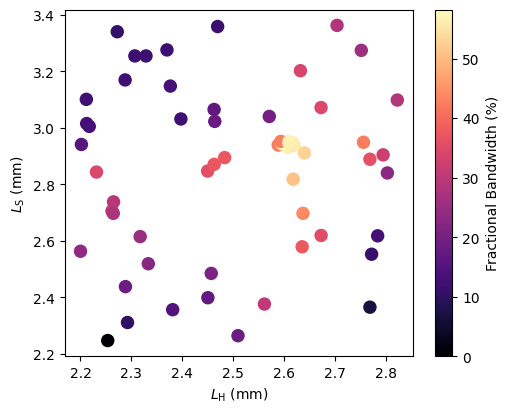

In [10]:
f, ax1 = plt.subplots(1, 1, figsize=(5, 4))
result_df_process = copy(result_df)
result_df_process["l_head"] = result_df_process["l_head"] * 1e-3
result_df_process["l_stem"] = result_df_process["l_stem"] * 1e-3
result_df_process = result_df_process.rename(columns={"output": "Fractional Bandwidth (%)"})
im = result_df_process.plot.scatter(
    x="l_head", y="l_stem", s=75, c="Fractional Bandwidth (%)", cmap="magma", ax=ax1
)
ax1.set_xlabel(r"$L_{\rm H}$ (mm)")
ax1.set_ylabel(r"$L_{\rm S}$ (mm)")
plt.tight_layout(pad=0.2)
plt.show()

Finally, we plot the co- and cross-polarization reflection coefficients from the design with the maximum fractional bandwidth, over the frequencies from 4 GHz to 16 GHz.

Range 7.60-13.84 GHz, Bandwidth: 6.24 GHz, Fractional Bandwidth: 58.21%


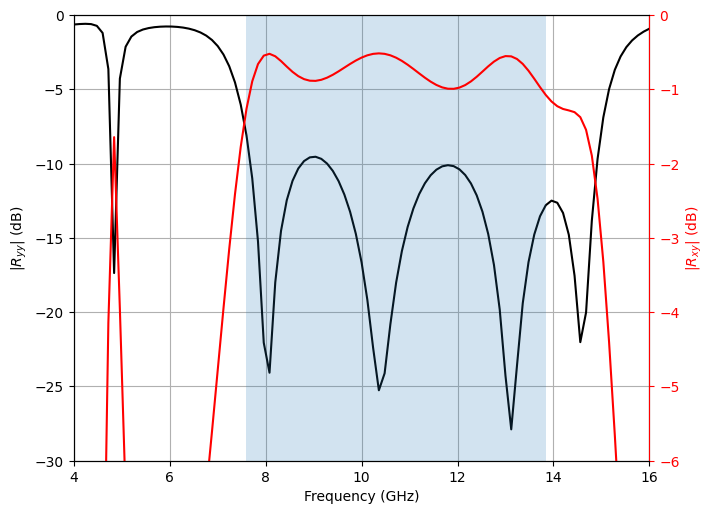

In [11]:
idx = result_df["output"].idxmax()
name = results.task_paths[idx]
sim_data = td.SimulationData.from_file(name)

flux_x, flux_y = compute_flux_polarization_components(sim_data[R_mon.name])
Rxy_dB = 10 * np.log10(flux_x.squeeze())
Ryy_dB = 10 * np.log10(flux_y.squeeze())
low_f, high_f = find_frequency_bounds(Rxy_dB)
bandwidth = high_f - low_f
fractional_bandwidth = calculate_fractional_bandwith_metric(sim_data[R_mon.name])
print(
    f"Range {low_f * 1e-9:.2f}-{high_f * 1e-9:.2f} GHz, Bandwidth: {bandwidth * 1e-9:.2f} GHz, Fractional Bandwidth: {fractional_bandwidth:.2f}%"
)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sub_ax = ax
ax2 = sub_ax.twinx()
(p1,) = sub_ax.plot(freqs / 1e9, Ryy_dB, "-k", label="Ryy-1")
(p2,) = ax2.plot(freqs / 1e9, Rxy_dB, "-r", label="Rxy-1")
ax2.axvspan(low_f / 1e9, high_f / 1e9, alpha=0.2)
sub_ax.set_xlabel("Frequency (GHz)")
sub_ax.set_ylabel(r"$|R_{yy}|$ (dB)")
sub_ax.set_xlim(4, 16)
sub_ax.set_xticks([4, 6, 8, 10, 12, 14, 16])
sub_ax.set_ylim(-30, 0)
sub_ax.grid(True)
ax2.set_ylabel(r"$|R_{xy}|$ (dB)")
ax2.set_ylim(-6, 0)

# Set axis colors
sub_ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
sub_ax.spines["right"].set_edgecolor(p1.get_color())
ax2.spines["right"].set_edgecolor(p2.get_color())
sub_ax.tick_params(axis="y", colors=p1.get_color())
ax2.tick_params(axis="y", colors=p2.get_color())
plt.tight_layout(pad=0.2)
plt.show()

## References

[1] H. Luyen, Z. Zhang, J. H. Booske, and N. Behdad, “Wideband, beam-steerable reflectarrays based on minimum-switch topology, polarization-rotating unit cells,” *IEEE Access*, vol. 7, pp. 36 568–36 578, 2019.